# Logistic regression

In the previous lecture, we studied how to predict continuous variables using linear models with shrinkage. We now turn to one of the most classical machine learning tasks, classification. To this end, we study the simplified setting where we have only two classes (labeled 0 and 1) so that the outcome is $y_i \in \{0,1\}$, and we want to train a model to predict the class membership of observations based on some features $\mathbf{x}_i$.

The classical approach to perform this task is to assume that the probability of the outcome 1 is given by
$$
p(\mathbf{x}_i) \equiv 
\text{Prob}\bigl(y_i = 1 ~|~\mathbf{x}_i\bigr) 
    = \frac{1}{1 + \exp\left(\mu + \mathbf{x}_i'\bm\beta\right)}
$$
where the function on the right $\sigma(z) = \frac{1}{1+e^{-z}}$ is called the 
[sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function) 
in machine learning or the [logistic](https://en.wikipedia.org/wiki/Logistic_distribution)
cumulative distribution function (CDF) in statistics and econometrics. 
Note that this function maps any (positive or negative) real value $z$ into a value between $(0, 1)$,
and hence is well-suited to model the probability that $y_i = 1$.

We can easily verify this by plotting the logistic CDF from `scipy.stats`:


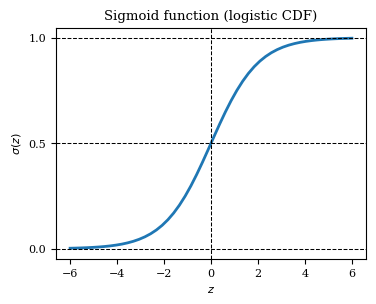

In [1]:
import numpy as np
from scipy.stats import logistic
import matplotlib.pyplot as plt

zvalues = np.linspace(-6, 6, 50)

plt.plot(zvalues, logistic.cdf(zvalues), lw=2.0)
# Add horizontal and vertical lines
for y in (0.0, 0.5, 1.0):
    plt.axhline(y, ls='--', lw=0.75, c='black')
plt.axvline(0.0, ls='--', lw=0.75, c='black')
plt.xlabel('$z$')
plt.ylabel(r'$\sigma(z)$')
plt.yticks([0.0, 0.5, 1.0])
_ = plt.title('Sigmoid function (logistic CDF)')

As you can see, the value of $\sigma(z)$ tends to 0 for small (negative) $z$, and it approaches 1 for large values of $z$.

In machine learning, the logistic regression is categorized as a linear model (see the scikit-learn user guide on [linear models](https://scikit-learn.org/stable/modules/linear_model.html)) even though $\sigma(z)$ is clearly not linear.
This is because the index $z_i$ that enters the sigmoid function is assumed to be linear in features,
$$
z_i = \mu + \mathbf{x}_i'\bm\beta
$$
Consequently, one can show that the log odds ratio is a linear function of features:
$$
\log\left( \frac{p(\mathbf{x}_i)}{1-p(\mathbf{x}_i)} \right) = \mu + \mathbf{x}_i'\bm\beta
$$

Before we can fit the model using logistic regression, we need to define an appropriate loss function. This loss function is 
derived from the log likelihood function of a binary logit model, defined as
$$
\mathcal{L}(\mu,\bm\beta) =
    \sum_{i=1}^N y_i \log\bigl(p(\mathbf{x}_i)\bigr) 
        + (1-y_i) \log\bigl(1-p(\mathbf{x}_i)\bigr)
$$
The details underlying the derivation of this likelihood function are beyond the scope of this course. For our purposes, it's sufficient to know that in maximum likelihood estimation (MLE), the parameters $\mu$ and $\bm\beta$ are chosen so that the log likelihood $\mathcal{L}$ of observing a given sample of $(y_i,\mathbf{x}_i)$ is *maximized*. 

To derive the loss function $L$ for the logistic regression, we simply take the *negative* log-likelihood function and find the parameters $(\mu, \bm\beta)$ which *minimize* the loss $L$:
$$
L(\mu, \bm\beta) = 
- \underbrace{\frac{1}{N} \mathcal{L}(\mu,\bm\beta)}_{\text{scaled log likelihood}} 
+ \underbrace{\frac{r(\bm\beta)}{C}}_{\text{regularization}}
$$
Moreover, we have already incorporated the scaled regularization term $\frac{r(\bm\beta)}{C}$ which is used analogously to Ridge regression and Lasso to shrink the parameters $\bm\beta$ and prevent overfitting.
The fitted logistic regression parameters are thus
$$
\left(\widehat{\mu}, \widehat{\bm\beta}\right) = 
\argmin_{\mu,\bm\beta} L(\mu,\bm\beta)
$$


***
## Example: Predicting binary class membership

To illustrate how to work with logistic regression, we create an artificial sample with two features $(x_{1i}, x_{2i})$ that are mapped into a binary outcome $y_i \in \{0,1\}$. We restrict our attention to only two features since this makes it easy to plot decision regions.

### Creating a demo data set 

Assume that the data-generating process can be characterized as follows:
$$
y_i = 
\begin{cases}
    1 & \text{if }~ f(x_{1i}, x_{2i}) + \epsilon_i \geq 0 \\
    0 & \text{else} 
\end{cases}
$$
where $f(\bullet)$ is some deterministic function of $(x_{1i}, x_{2i})$ and $\epsilon_i$ is an error term.
For illustration, we'll again assume that $f(\bullet)$ is a combination of trigonometric functions 
which we'll attempt to approximate using polynomials. Specifically, the model studied in this section is
$$
\begin{aligned}
f(x_{1i}, x_{2i}) &= \sin(2\pi x_{1i}) \cos(\pi x_{2i}) \\
\epsilon_i &\stackrel{\text{iid}}{\sim} \mathcal{N}\left(0, \sigma_{\epsilon}^2\right)
\end{aligned}
$$

The code below defines $f(x_{1i}, x_{2i})$ and plots the function on rectangular grid which we create with 
[`np.meshgrid()`](https://numpy.org/doc/2.2/reference/generated/numpy.meshgrid.html).

In [2]:
import numpy as np

def f(x1, x2):
    """
    True function for classification example
    """
    return np.sin(2*np.pi*x1) * np.cos(np.pi*x2)

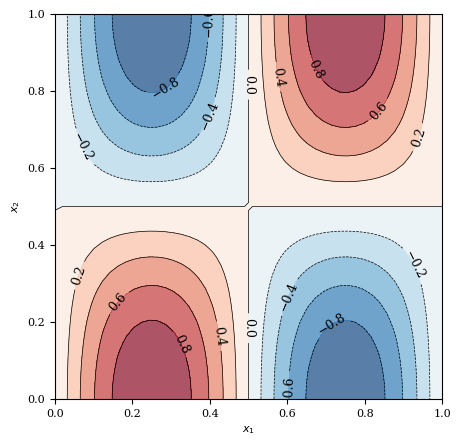

In [3]:
import matplotlib.pyplot as plt

# x-values for grid
x = np.linspace(0, 1, 50)

# Create coordinates for x1 and x2
x1_grid, x2_grid = np.meshgrid(x, x)

# Deterministic function f(x1, x2)
z = f(x1_grid, x2_grid)

# Contour plot of deterministic function
plt.figure(figsize=(5, 5))
levels = np.linspace(-1, 1, 11)
cntrf = plt.contourf(x1_grid, x2_grid, z, levels=levels, cmap="RdBu_r", alpha=0.7)
CS = plt.contour(x1_grid, x2_grid, z, levels=levels, linewidths=0.5, colors='k')
plt.clabel(CS, CS.levels, fontsize=9)
plt.xlabel('$x_1$')
_ = plt.ylabel('$x_2$')

As you see, this function takes on positive values in two quadrants (where $y_i$ is thus 1) and negative values in the other two (where $y_i$ is therefore 0). Without some noise $\epsilon_i$, class membership would be trivial to predict, so we next create a sample that incorporates noise.

In [4]:
# Enable automatic reloading of external modules
%load_ext autoreload
%autoreload 2

In [5]:
from lecture12_classifiers import create_class_data

# Sample size
N = 100

# Standard deviation of noise
sigma_eps = 0.2

# Create demo data set for classification
X, y = create_class_data(N=N, sigma=sigma_eps)

The last line in the previous code segment converts the latent continuous variable $z_i$ to $y_i \in \{0, 1\}$. We can verify that $y_i$ take on only two values with class labels 0 and 1:

In [6]:
classes = np.unique(y)
classes

array([0, 1])

Next, we import the function `plot_classes()` defined in `lecture12_classifiers.py` which creates a scatter plot from the sample and uses different marker symbols based on the class labels.

We will use this function repeatedly to plot the sample data and model predictions. The figure below visualizes the artificial sample we have just created. As you can see, unlike in the previous graph the class membership is no longer clearly split between quadrants due to the additional noise $\epsilon_i$.

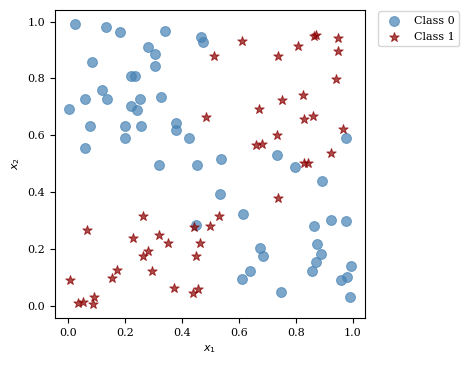

In [7]:
from lecture12_classifiers import plot_classes

_ = plot_classes(X, y)

***
### Fitting a simple model

As usual, before fitting the model, we first split the sample into a training and a test set.
Unlike with linear regression models (Ridge, Lasso, OLS), it is advantageous to use *stratification* when splitting the sample so that both the training and test samples contain an approximately equal share of each class. We accomplish this by specifying the `stratify` keyword argument uses the values of the target variable $y$ for stratification.

In [8]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=1234
)

Of course, given randomness and the small sample size used here, the share of classes will not be exactly identical across the training and test samples, as the following code shows:

In [9]:
import pandas as pd

print('Distribution of classes in training sample:')
print(pd.Series(y_train).value_counts() / len(y_train))

print('\nDistribution of classes in test sample:')
print(pd.Series(y_test).value_counts() / len(y_test))

Distribution of classes in training sample:
0    0.542857
1    0.457143
Name: count, dtype: float64

Distribution of classes in test sample:
0    0.533333
1    0.466667
Name: count, dtype: float64


We can now plot the training and test samples, using different marker symbols for each:

In [10]:
plot_classes(X_train, y_train, X_test, y_test)

<Axes: xlabel='$x_1$', ylabel='$x_2$'>

We proceed to fit the model using the
[`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) 
estimator from scikit-learn. `LogisticRegression` implements four different types of regularization: 

1.  the L1 penalty we encountered with Lasso; 
2.  the L2 penalty from the Ridge regression; 
3.  the convex combination of these used for the elastic net; or 
4.  no penalty (this then corresponds to the classical binary logit used in econometrics to model discrete choice).

The following table lists the available regularization terms and their corresponding `penalty` arguments 
that can be used when creating an instance of `LogisticRegression`:

| Penalty | $r(\bm\beta)$                          | `penalty` argument |
|---------------------|----------------------------|---------------------|
| L1   | $r(\bm\beta) = \|\bm\beta\|_1 = \sum_{k=1}^K \|\beta_k\|$ | `'l1'` |
| L2   | $r(\bm\beta) = \frac{1}{2} \|\bm\beta\|_2^2 = \frac{1}{2} \sum_{k=1}^K \beta_k^2$ | `'l2'` |
| L1 and L2 | $r(\bm\beta) = \rho \|\bm\beta\|_1 + \frac{1-\rho}{2} \|\bm\beta\|_2^2$  | `'ElasticNet'` |
| None | | `None` |

We first experiment with the simplest possible linear model with
$$
z_i = \mu + \beta_1 x_{1i} + \beta_2 x_{2i}
$$
so that the probability of observing class 1 is
$$
p(\mathbf{x}_i) \equiv 
\text{Prob}\bigl(y_i = 1 ~|~\mathbf{x}_i\bigr) 
    = \frac{1}{1 + \exp\left(\ \mu + \beta_1 x_{1i} + \beta_2 x_{2i}\right)}
$$
Moreover, for now we skip including a regularization term (`penalty=None`).

In [11]:
# TODO: For now, suppress deprecation warnings due to sklearn 1.8
import warnings
import os
warnings.filterwarnings("ignore")
# Removes warnings in the spawned jobs
os.environ['PYTHONWARNINGS']='ignore'

In [12]:
from sklearn.linear_model import LogisticRegression

# Create logistic regression model without regularization penalty
lr = LogisticRegression(
    penalty=None, 
    fit_intercept=True, 
    max_iter=1000
)

In [13]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, penalty=None)

### Assessing model accuracy

We first plot the decision boundaries implied by the fitted model. To this end, we use the helper function `plot_decision_boundary()` implemented in `lecture12_classifiers.py`. The function takes as argument an existing Matplotlib `Axes` object and adds the decision boundaries to an existing figure.

In [14]:
from lecture12_classifiers import plot_decision_boundary

# Create x-values used to evaluate decisions
xvalues = np.linspace(0, 1, 1000)

ax = plot_classes(X_train, y_train, X_test, y_test)
plot_decision_boundary(ax, xvalues, lr)
_ = ax.set_title('Classification with logistic regression')

As you see, the simple linear model does a rather poor job predicting class membership and misclassifies many observations. The graph shows that for any combination $(x_{1i}, x_{2i})$ falling into the blue area, the fitted model predicts $y_i = 0$, whereas in the red area it predicts $y_i = 1$.

We can explicitly compute the accuracy, i.e., the share of correctly predicted class labels, using the `score()` method of the estimator, or the 
[`accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
function. These return the same results.

In [15]:
# Predict y on training and test samples
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [16]:
from sklearn.metrics import accuracy_score

# Compute accuracy on training and test sets
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print(f'Accuracy on training sample: {acc_train:.3f}')
print(f'Accuracy on test sample: {acc_test:.3f}')

Accuracy on training sample: 0.443
Accuracy on test sample: 0.500


Alternatively, we can use the `score()` method directly to compute the same statistic, for example on the test sample:

In [17]:
acc_test = lr.score(X_test, y_test)
print(f'Accuracy on test sample: {acc_test:.3f}')

Accuracy on test sample: 0.500


There are other metrics to assess how well the model predicts class labels. These usually combine the elements of the confusion matrix in some way. First, consider the confusion matrix for a generic classification problem (with labels `P` and `N` for `Positive` and `Negative`), plotted below:

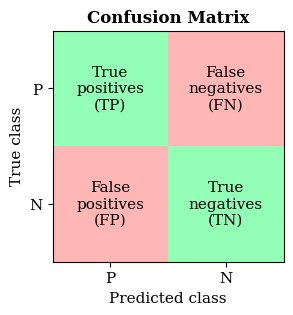

In [18]:
from lecture12_classifiers import plot_generic_confusion_matrix
plot_generic_confusion_matrix()

As you see, a classifier would ideally make predictions on some sample of known labels which are located in the green quadrants. Using the labels of this matrix, the accuracy score we have computed above is given by
$$
ACC = \frac{TP + TN}{FP + FN + TP + TN}
$$
However, we might be interest in different measures, for example *precision*, defined as
$$
PRE = \frac{TP}{TP + FP}
$$
or *recall*, defined as 
$$
REC = \frac{TP}{FN + TP}
$$
Another commonly used scoring metric is the so-called *F1 score*, which is computed as
$$
F1 = 2 \frac{PRE \cdot REC}{PRE + REC}
$$
Which of these metrics to use depends on the scenario. For example, we could have a sample where there are only very few positive observations, so a model that always predicts the negative label will have a high accuracy. On the other hand, it will do poorly measured by *recall*.

scikit-learn implements many commonly used scoring metrics in the module
[sklearn.metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html). Using functions from that module, 
we can compute the metrics defined above:


In [19]:
from sklearn.metrics import recall_score, precision_score, f1_score

# Precision
pre = precision_score(y_test, y_test_pred)
# Recall
rec = recall_score(y_test, y_test_pred)
# F1 score
f1 = f1_score(y_test, y_test_pred)

print(f'Precision: {pre:.3f}')
print(f'Recall: {rec:.3f}')
print(f'F1 score: {f1:.3f}')

Precision: 0.400
Recall: 0.143
F1 score: 0.211


As you can see, the logistic regression with a linear index performs even poorer on some of these metrics than suggested by the accuracy score.

Finally, we can plot the confusion matrix using the class 
[ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions).
This plot can be created from the predicted values or directly from the estimator.
We demonstrate how the confusion can be plotted from the predicted values below:

Text(0.5, 1.0, 'Confusion matrix for linear index')

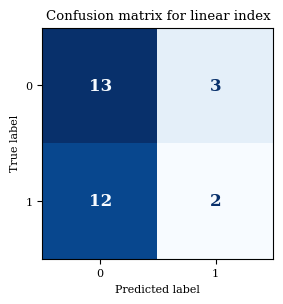

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

# Plot confusion matrix from predicted values
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred,
    colorbar=False,
    cmap='Blues',
    text_kw={'fontsize': 12, 'fontweight': 'bold'},
).ax_.set_title('Confusion matrix for linear index')

### Digression: linear decision boundary

You might wonder why the decision boundary plotted earlier is a straight line even though the sigmoid function is clearly nonlinear. This arises because `LogisticRegression` assigns predictions based on the most likely class as determined by the predicted probabilities of belonging to each class for each observations. We can predict these underlying probabilities using the 
[`predict_proba()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) 
method, for example for the test sample:

In [21]:
# Predict probabilities for first five test samples
lr.predict_proba(X_test)[:5]

array([[0.51830556, 0.48169444],
       [0.55159038, 0.44840962],
       [0.59726736, 0.40273264],
       [0.46472375, 0.53527625],
       [0.57511958, 0.42488042]])

Based on these predicted probabilities, `LogisticRegression` assigns the predicted class as the most likely outcome. With only two categories, $y_i = 1$ is therefore predicted whenever the value in the second column is larger than 0.5. Plugging this into the sigmoid function, we have

$$
\begin{aligned}
y_i = 1 
& \Longleftrightarrow \sigma( \mu + \beta_1 x_{1i} + \beta_2 x_{2i}) \geq 0.5 \\
& \Longleftrightarrow
\frac{1}{1+\exp\left(-\mu - \beta_1 x_{1i} - \beta_2 x_{2i}\right)} \geq 0.5 \\
& \Longleftrightarrow
\exp\left(-\mu - \beta_1 x_{1i} - \beta_2 x_{2i}\right) \leq 1 \\
& \Longleftrightarrow
\mu + \beta_1 x_{1i} + \beta_2 x_{2i} \geq 0 \\
& \Longleftrightarrow
x_{2i} \leq \frac{\mu}{\beta_2} + \frac{\beta_1}{\beta_2} x_{1i}
\end{aligned}
$$

The last step above follows because $\beta_2 < 0$ in this example as you can verify by checking the attribute `lr.coef_`. The take-away from these derivations is that any combination of features $x_{1i}, x_{2i}$ is mapped to $y_i = 1$ if $x_{2i}$ lies underneath the line defined by $\frac{\mu}{\beta_2} + \frac{\beta_1}{\beta_2} x_{1i}$, and therefore the decision boundary is a *straight line*.

***
### Fitting a model with polynomials

We now extend the simple model and approximate the true trigonometric relationship between $y_i$ and $\mathbf{x}_i$ using polynomials in $x_{1i}, x_{2i}$ where we allow for interaction terms up to some upper bound.

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

# Maximum polynomial degree
degree = 5

# Create pipeline with polynomial features and logistic regression
pipe_lr = make_pipeline(
    PolynomialFeatures(degree=degree, include_bias=False),
    StandardScaler(),
    LogisticRegression(
        fit_intercept=True, penalty=None, max_iter=1000, random_state=1234
    ),
)

At this point we strictly speaking don't need to scale the polynomial features using the `StandardScaler`, but this will be necessary below when we introduce a regularization term.

We can now fit the model on the training data:

In [23]:
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=5, include_bias=False)),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, penalty=None,
                                    random_state=1234))])

Using the functions defined above, we can plot the decision boundaries of this more complex model:

In [24]:
# Create x-values used to evaluate decisions
xvalues = np.linspace(0, 1, 1000)
ax = plot_classes(X_train, y_train, X_test, y_test)
plot_decision_boundary(ax, xvalues, pipe_lr)
_ = ax.set_title('Classification with logistic regression (polynomials)')

The substantial increase in model fit is immediately apparent. Using the accuracy score, we can confirm that the model is indeed much better predicting the class labels on the test sample:

In [25]:
# Predict y on test sample
y_test_pred = pipe_lr.predict(X_test)

acc_test = accuracy_score(y_test, y_test_pred)
pre_test = precision_score(y_test, y_test_pred)
rec_test = recall_score(y_test, y_test_pred)

print(f'Accuracy on test sample: {acc_test:.3f}')
print(f'Precision on test sample: {pre_test:.3f}')
print(f'Recall on test sample: {rec_test:.3f}')

Accuracy on test sample: 0.767
Precision on test sample: 0.733
Recall on test sample: 0.786


Using polynomials, the model predicts around 77% of cases in the test sample correctly. Plotting the confusion matrix, we also see that more of the true-predicted combinations are along the diagonals.

Text(0.5, 1.0, 'Confusion matrix for linear index')

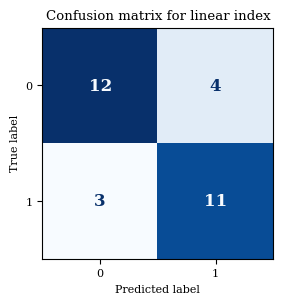

In [26]:
# Plot confusion matrix from predicted values
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred,
    colorbar=False,
    cmap='Blues',
    text_kw={'fontsize': 12, 'fontweight': 'bold'},
).ax_.set_title('Confusion matrix for linear index')

***
### Cross-validating the penalty term

So far, we haven't introduced a regularization term when fitting the logistic regression. Analogous to Ridge regression and Lasso, regularization can be used to prevent overfitting.

Since we don't know the "best" regularization parameter $C$, we use 
[LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) to perform cross-validation.


As is the case with most specific cross-validation classes in scitkit-learn,
`LogisticRegressionCV` does not support pipelines, so we need to manually
create the polynomials and apply standardization on the training set before
we run cross-validation:

In [27]:
from sklearn.linear_model import LogisticRegressionCV

# Pipeline to create polynomial features and standardize them
transform = make_pipeline(
    PolynomialFeatures(degree=degree, include_bias=False), StandardScaler()
)

# Fit and transform training data
X_train_poly = transform.fit_transform(X_train)

We can now run the cross-validation. For this we choose the L2 penalty (the same as for Ridge regression), we use 10 folds, and tell 
`LogisticRegressionCV` to choose 50 values of $C$ which are uniformly spaced
in logs between the values 1e-4 and 1e4.

In [28]:
# Create and run Logistic regression cross-validation
lrcv = LogisticRegressionCV(
    Cs=50,                      # Number of C to try, spaced uniformly in logs
    cv=10,                      # Number of folds
    fit_intercept=True,         # Fit intercept
    penalty='l2',               # Use L2 penalty
    max_iter=1000,              # Maximum iterations (increase from default)
    n_jobs=4,                   # Number of parallel jobs
    random_state=1234,          # Random seed
)

# Run cross-validation
lrcv.fit(X_train_poly, y_train)

LogisticRegressionCV(Cs=50, cv=10, max_iter=1000, n_jobs=4, penalty='l2',
                     random_state=1234)

Once the cross-validation is done, we can extract the best penalty parameter $C$ from the array attribute `C_`.

In this case, the optimal $C$ is given by

In [29]:
print(f'Best C: {lrcv.C_[0]:.4f}')

Best C: 35.5648


Note that unlike the penalty parameters used for Ridge and Lasso, $C$ in this case is the *inverse* penalty strength, i.e., larger values of $C$ introduce a *smaller* penalty.

Finally, we recreate the whole pipeline we had earlier but use the optimal penalty parameter. This is not necessary if we just want to compute predicted values or accuracy metrics, but the plotting functions we have created expected the estimator pipeline to also create the polynomial features and perform standardization.

In [30]:
# Create pipeline using cross-validated C
lr_opt = make_pipeline(
    PolynomialFeatures(degree=degree, include_bias=False),
    StandardScaler(),
    LogisticRegression(
        C=lrcv.C_[0], 
        fit_intercept=True, 
        penalty='l2', 
        max_iter=1000,
        random_state=1234
    ),
).fit(X_train, y_train)

We reuse the plotting code from above to plot the decision boundaries for the optimal model:

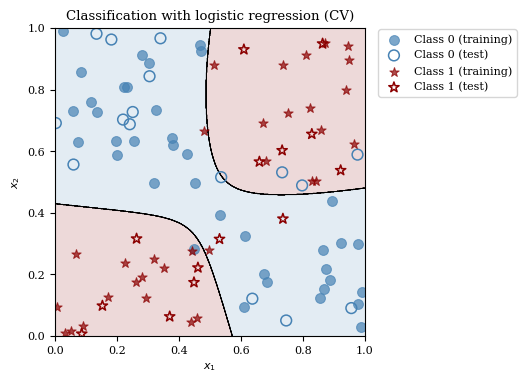

In [31]:
# Create x-values used to evaluate decisions
xvalues = np.linspace(0, 1, 1000)
ax = plot_classes(X_train, y_train, X_test, y_test)
plot_decision_boundary(ax, xvalues, lr_opt)
_ = ax.set_title('Classification with logistic regression (CV)')

There are slight improvements compared to the model without the penalty term. We can also confirm that the accuracy score for the test data increased from around 77% to 83%:

In [32]:
# Compute accuracy of cross-validated model on test data
y_test_pred = lr_opt.predict(X_test)

acc_test = accuracy_score(y_test, y_test_pred)
pre_test = precision_score(y_test, y_test_pred)
rec_test = recall_score(y_test, y_test_pred)

print(f'Accuracy on test sample: {acc_test:.3f}')
print(f'Precision on test sample: {pre_test:.3f}')
print(f'Recall on test sample: {rec_test:.3f}')

Accuracy on test sample: 0.833
Precision on test sample: 0.800
Recall on test sample: 0.857


Note that the model above has a second hyperparameter, the maximum number of polynomial degrees, which we fixed at 5 for the entire cross-validation. In theory, we could perform the cross-validation *jointly* on the polynomial degree and $C$ at the same time for even better results.

***
### Validation curves

We conclude this section with plotting the validation curve for 
the above example as we vary the penalty parameter $C$. Recall that the
validation curve plots some metric of model performance (in this case 
the accuracy score) computed from the validation sample against a range of values for a hyperparameter, in this case $C$ (see the scikit-learn 
[documentation](https://scikit-learn.org/stable/modules/learning_curve.html#validation-curve) 
for details).


We can leverage scikit-learn's 
[`validation_curve()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html)
function to perform this task for us.
Since `validation_curve()` does work with pipelines, we first create 
the usual pipeline to create the polynomial features, perform standardization,
and add a logistic regression estimator where we specify penalty
to be of L2 type.

In [33]:
pipe_lr = make_pipeline(
    PolynomialFeatures(degree=degree, include_bias=False),
    StandardScaler(),
    LogisticRegression(
        fit_intercept=True, 
        penalty='l2', 
        max_iter=1000,
        random_state=1234
    ),
)

`validation_curve()` uses two arguments to specify which parameter should be varied:

-   `param_name` specifies the attribute which stores the parameter to be varied.
    In case of pipelines, this name takes the form `STEPNAME_ATTRIBUTE`
    where `STEPNAME` is the name of the step in the pipeline, 
    and `ATTRIBUTE` is the name of the attribute of that particular step to
    be varied.

-   `param_range` specifies the range of parameter values to be varied
    along the validation curve.

For our specific logistic regression pipeline, the call to `validation_curve()`
looks as follows:

In [34]:
from sklearn.model_selection import validation_curve

# Define range of values for C, spaced uniformly in logs
param_range = np.logspace(-4, 4, 20)

# Compute validation curve
train_scores, test_scores = validation_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    param_name='logisticregression__C',
    param_range=param_range,
    cv=10,
    n_jobs=4,
)

The module `lecture12_classifiers` implements the function `plot_accuracy_validation_curve()`  which we can use to plot the validation curve for a given range of parameter values:

In [35]:
from lecture12_classifiers import plot_accuracy_validation_curve

plot_accuracy_validation_curve(param_range, train_scores, test_scores)

As the plot below suggests, for small $C$ (i.e., for very large penalty strengths), the model underfits the data both in the training and test samples, leading to low accuracy. For very high values of $C$, on the other hand, the model overfits, leading to lower accuracy in the test sample (but increasing accuracy in the training sample).

***
# Other commonly used classifiers

In this section, we study three other widely used classifiers implemented in scikit-learn:

1.  Support vector machines (SVM);
2.  Decision trees; and
3.  Random forests

These classifiers should be viewed as alternatives to logistic regression studied earlier. In fact, because of the composable API of scikit-learn, it is usually trivial to switch out the `LogisticRegression` class in a processing and estimation pipeline, so one can (and should) easily experiment with several classifiers to determine which yields the best accuracy for a given task.

When running any of these classifiers, we need to be aware that they differ in terms of data processing, estimation and cross-validation:

1.  Some classifiers like `LogisticRegression` have a fixed functional form (given by the sigmoid function), so we might need to expand the feature space by creating polynomial interactions or similar, as we have done previously. This step is not needed for decision trees or random forests, and it is most likely not needed for SVM because we can select a different kernel to create a nonlinear model instead of resorting to a polynomial basis.

2.  Some classifiers *require* feature standardization (in particular, this is true 
    for logistic regression with regularization and SVM), whereas this step is not necessary
    for decision trees or random forests.

3.  Classifiers differ in their hyperparameters, and different types of cross-validation might need to 
    be performed for different classifiers.

***
## Support vector machines (SVM)

scikit-learn offers several implementations of SVMs that differ in the underlying algorithm and capabilities. We focus on the 
[`SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
(support vector classifier) class which supports both linear and nonlinear kernels.

Just like logistic regression, `SVC` uses the regularization parameter $C$. However,
SVMs offer additional flexibility in that they support various kernels. You can think
of a kernel as a function that operates on the features and projects them onto a different space. For example, we might have a classification problem like the one we studied above, where the classes
0 and 1 clearly cannot be separated by a single linear boundary. Instead of adding polynomial 
interactions, with SVMs we can specify a nonlinear kernel in the hope that once the features
have been transformed using this kernel, the individual classes become much easier to separate.

### Linear kernel

For illustration purposes, we first create the a new artificial data set for classification
with more observations and more noise to magnify the difference between SVM kernels and hyperparameters (with the original demo sample, all but the simplest linear SVM yield basically the same result).

In [36]:
# Sample size
N = 200

# Create demo data for binary classification
sigma_eps = 0.25

# Create data set
X, y = create_class_data(N=N, sigma=sigma_eps)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=1234
)

We start with the simplest linear kernel which is selected using
the `kernel='linear'` argument.

In [37]:
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

# Create pipeline with with linear SVM
pipe_svm = make_pipeline(
    StandardScaler(),
    SVC(kernel='linear', C=1.0, random_state=1234)
).fit(X_train, y_train)

Plotting the decision boundaries, we see that the linear kernel leads to a single linear decision boundary:

In [38]:
xvalues = np.linspace(0, 1, 1000)
ax = plot_classes(X_train, y_train, X_test, y_test)
plot_decision_boundary(ax, xvalues, pipe_svm)
_ = ax.set_title('Classification with SVM (linear)')

This model is not doing overly great in terms of accuracy, classifying only about 71% of test samples correctly:

In [39]:
y_train_pred_svm = pipe_svm.predict(X_train)
y_test_pred_svm = pipe_svm.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred_svm)
acc_test = accuracy_score(y_test, y_test_pred_svm)

print(f'Accuracy on training sample: {acc_train:.3f}')
print(f'Accuracy on test sample: {acc_test:.3f}')

Accuracy on training sample: 0.729
Accuracy on test sample: 0.683


As with logistic regression, we can easily augment this model by adding polynomial interactions of features:

In [40]:
# Fit linear SVM with polynomial features

# Maximum polynomial degree
degree = 5

# Create pipeline with polynomial features and SVM
pipe_svm_poly = make_pipeline(
    PolynomialFeatures(degree=degree, include_bias=False),
    StandardScaler(),
    SVC(kernel='linear', C=1.0, random_state=1234)
).fit(X_train, y_train)

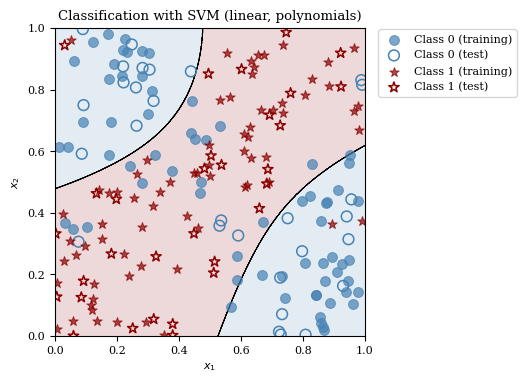

In [41]:
xvalues = np.linspace(0, 1, 1000)
ax = plot_classes(X_train, y_train, X_test, y_test)
plot_decision_boundary(ax, xvalues, pipe_svm_poly)
_ = ax.set_title('Classification with SVM (linear, polynomials)')

This yields considerably higher accuracy on the test sample:

In [42]:
y_train_pred_svm = pipe_svm_poly.predict(X_train)
y_test_pred_svm = pipe_svm_poly.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred_svm)
acc_test = accuracy_score(y_test, y_test_pred_svm)

print(f'Accuracy on training sample: {acc_train:.3f}')
print(f'Accuracy on test sample: {acc_test:.3f}')

Accuracy on training sample: 0.850
Accuracy on test sample: 0.883


### Gaussian kernel

However, it is not necessary to introduce polynomial features with SVM. Alternatively, we can operate with just the two original features, but choose a different kernel. By default, the kernel used by `SVC` is 
`kernel='rbf'` which stands for the *radial basis function*. This kernel is also called the Gaussian kernel.

We rerun the above code, omitting the polynomial features but instead selecting the Gaussian kernel:

In [43]:
# Create SVM with RBF kernel
pipe_svm_rbf = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=1.0, gamma='scale', random_state=1234)
).fit(X_train, y_train)

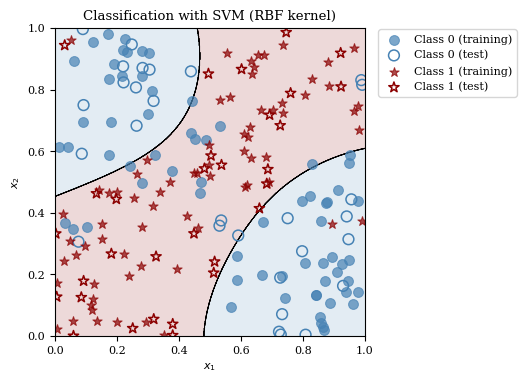

In [44]:
ax = plot_classes(X_train, y_train, X_test, y_test)
plot_decision_boundary(ax, xvalues, pipe_svm_rbf)
_ = ax.set_title('Classification with SVM (RBF kernel)')

The decision boundaries are quite similar to the linear kernel with polynomials, as is the accuracy of the fitted model:

In [45]:
y_train_pred_svm = pipe_svm_rbf.predict(X_train)
y_test_pred_svm = pipe_svm_rbf.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred_svm)
acc_test = accuracy_score(y_test, y_test_pred_svm)

print(f'Accuracy on training sample: {acc_train:.3f}')
print(f'Accuracy on test sample: {acc_test:.3f}')

Accuracy on training sample: 0.879
Accuracy on test sample: 0.883


So far, we haven't done any hyperparameter tuning. The RBF kernel has *two* hyperparameter arguments:

1.  `C`, the regularization penalty strength (which we encountered before); and
2.  `gamma`, which scales the Euclidean distance between any two feature vectors.

With two hyperparameters, we cannot resort to functions such as the `validation_curve()`
we used earlier to plot how accuracy changes with a hyperparameter. Instead, we use the
[`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
class which performs parameter tuning over a grid of *several* parameters (in this case, over `C` and `gamma`).
The parameter grid is specified using the `param_grid` argument which accepts a dictionary
with a list of candidate values for *each* parameter. The grid search is then performed over
the Cartesian product of these candidate values, so in the code below, $100 \times 100$
different combinations of parameters are evaluated.

In [46]:
from sklearn.model_selection import GridSearchCV

# Define range of values for C and gamma, spaced uniformly in logs
param_range = np.logspace(-1, 2, 100)

# Define param_grid argument for GridSearchCV
param_grid = {'svc__C': param_range, 'svc__gamma': param_range}

# Create grid search cross-validation object, run cross-validation
gs_rbf = GridSearchCV(
    estimator=pipe_svm_rbf,     # Model to tune
    param_grid=param_grid,      # Dictionary of hyperparameter grids
    cv=10,                      # Number of folds
    refit=True,                 # Refit best model
    n_jobs=8                    # Number of parallel jobs
).fit(X_train, y_train)

The best accuracy score and the optimal parameter values can be retrieved from the attributes `best_score_` and `best_params_`:

In [47]:
print(f'Best accuracy: {gs_rbf.best_score_:.3f}')
print(f'Best parameters: {gs_rbf.best_params_}')

Best accuracy: 0.907
Best parameters: {'svc__C': np.float64(53.366992312063125), 'svc__gamma': np.float64(10.722672220103231)}


Note that we don't need to re-estimate the model with these optimal parameters since we specified `refit=True` when creating an instance of `GridSearchCV`, so the resulting object already reflects the optimal model.

Finally, we can plot the decision boundaries for the cross-validated SVM model:

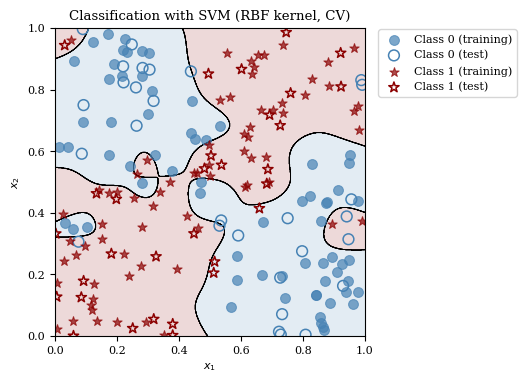

In [48]:
ax = plot_classes(X_train, y_train, X_test, y_test)
plot_decision_boundary(ax, xvalues, gs_rbf)
_ = ax.set_title('Classification with SVM (RBF kernel, CV)')

As you can suspect from the figure, the cross-validated model is in fact overfitting more than the one with default hyperparameters. This is confirmed by the accuracy score, which is *lower* on the test sample than it was before.

In [49]:
y_train_pred_svm = gs_rbf.predict(X_train)
y_test_pred_svm = gs_rbf.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred_svm)
acc_test = accuracy_score(y_test, y_test_pred_svm)

print(f'Accuracy on training sample: {acc_train:.3f}')
print(f'Accuracy on test sample: {acc_test:.3f}')

Accuracy on training sample: 1.000
Accuracy on test sample: 0.817


***
## Decision trees

Decision trees are a nonlinear classifier which are constructed by splitting the sample in two at each branch according to some criterion (e.g., if feature 1 is larger than a value $a$). Fitting a decision tree is the process of growing a tree and finding the criteria that split the sample to achieve the highest information gain. 

In principle, a tree could be grown until each leaf node is pure, i.e., it contains only observations from a single class. In practice, this can lead to very deep trees which tend to overfit the data, so it's advisable to prune the tree by specifying a maximum tree depth.

Decision trees are implemented in the 
[`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class in scikit-learn. 

To demonstrate their use, we recreate the
artificial classification sample we used for logistic regression earlier.

In [50]:
# Sample size
N = 100

# Create demo data for binary classification
sigma_eps = 0.2

# Create data set
X, y = create_class_data(N=N, sigma=sigma_eps)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=1234
)

We now grow the tree by fitting it to the training data. As explained above, we limit the maximum tree depth to 3 layers by specifying the argument `max_depth=3`.

It should be stressed that decision trees are a fully nonlinear model, so there is usually no need to expand the feature space using polynomial interactions. Moreover, decision trees are not sensitive to scaling, so we can skip the entire data processing pipeline we used for other classifiers.

In [51]:
from sklearn.tree import DecisionTreeClassifier

# Create decision tree classifier
tree = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=1234)

# Grow tree on training data (to transformation needed)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=1234)

We now plot the decision boundaries of the fitted decision tree. As you can see, the boundaries are all parallel to the axes, which is by construction.

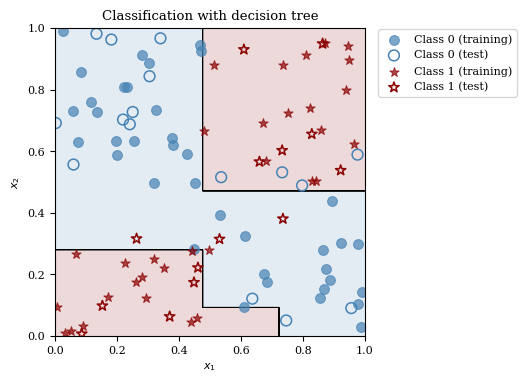

In [52]:
ax = plot_classes(X_train, y_train, X_test, y_test)
plot_decision_boundary(ax, xvalues, tree)
_ = ax.set_title('Classification with decision tree')

Computing the accuracy score, we see that the decision tree produces a worse result than the cross-validated logistic regression we used earlier:

In [53]:
y_train_pred_tree = tree.predict(X_train)
y_test_pred_tree = tree.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred_tree)
acc_test = accuracy_score(y_test, y_test_pred_tree)

print(f'Accuracy on training sample: {acc_train:.3f}')
print(f'Accuracy on test sample: {acc_test:.3f}')

Accuracy on training sample: 0.986
Accuracy on test sample: 0.767


scikit-learn offers a convenience function which allows us to visualize the decision tree which is depicted in the figure below. At each node, the first line states the criterion used to split the sample, the second line reports the sample size at the node before the split has been applied, and the third line reports the number of observations for each class label.

For example, at the top node, the sample is split according to whether the feature $x_{2i}$ is larger than 0.093 or not. As you can see, most of the bottom leafs are pure since they contain only observations of a single class.

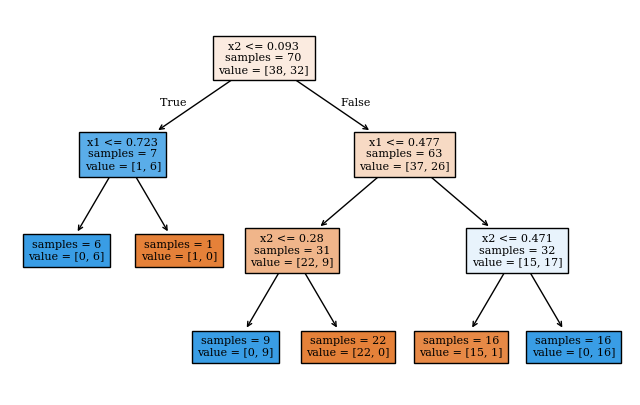

In [54]:
from sklearn.tree import plot_tree

# Visualize nodes of fitted decision tree
fig, ax = plt.subplots(figsize=(8, 5))
_ = plot_tree(
    tree, filled=True, feature_names=['x1', 'x2'], fontsize=8, impurity=False, ax=ax
)

We fitted the tree above choosing a maximum tree depth ourselves. Alternatively, we can use the
[`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
cross-validator to find the optimal tree depth for this sample as follows:

In [55]:
from sklearn.model_selection import GridSearchCV

# Define range of values for max_depth
param_range = np.arange(1, 11)

tree_cv = GridSearchCV(estimator=tree,
    param_grid={'max_depth': param_range},
    cv=10,
    refit=True,
    n_jobs=4
).fit(X_train, y_train)

print(f'Best accuracy: {tree_cv.best_score_:.3f}')
print(f'Best parameters: {tree_cv.best_params_}')

Best accuracy: 0.886
Best parameters: {'max_depth': np.int64(5)}


As you can see, the optimal cross-validated maximum depth is computed to be 5.

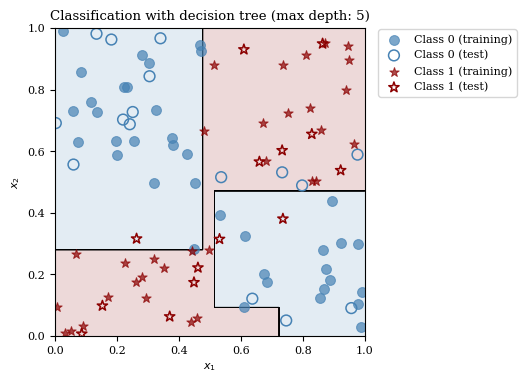

In [56]:
ax = plot_classes(X_train, y_train, X_test, y_test)
plot_decision_boundary(ax, xvalues, tree_cv)
_ = ax.set_title(
    f'Classification with decision tree (max depth: {tree_cv.best_params_["max_depth"]})'
)

The cross-validated maximum depth leads to a small increase in classification accuracy on the test sample:

In [57]:
y_train_pred_tree = tree_cv.predict(X_train)
y_test_pred_tree = tree_cv.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred_tree)
acc_test = accuracy_score(y_test, y_test_pred_tree)

print(f'Accuracy on training sample: {acc_train:.3f}')
print(f'Accuracy on test sample: {acc_test:.3f}')

Accuracy on training sample: 1.000
Accuracy on test sample: 0.767


***
## Random forest

A random forest classifier combines multiple decision trees on various subsamples of the data and averages their results. This model averaging is intended to lead to less overfitting and higher predictive accuracy.

The random forest classifier is implemented in 
[RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) in scikit-learn. The most important arguments 
are the number of decision trees to grow (`n_estimators`) and the maximum tree depth (`max_depth`).

Just like decision trees, a random forest is not sensitive to scaling, so we can skip the usual preprocessing pipeline.

In [58]:
from sklearn.ensemble import RandomForestClassifier

# Create random forest classifier, fit on training data
forest = RandomForestClassifier(
    n_estimators=100, max_depth=3, random_state=1234, n_jobs=4
).fit(X_train, y_train)

Compared to a single decision tree, the random forest leads to more granular decision boundaries which are due to the averaging of many decision trees.

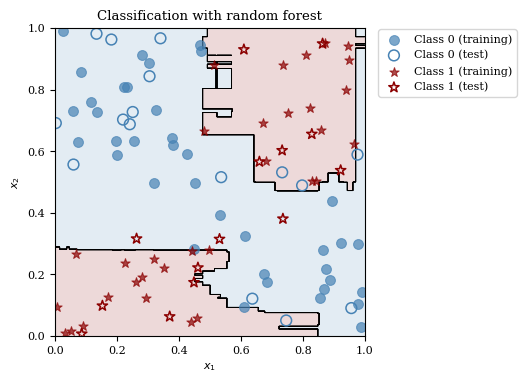

In [59]:
ax = plot_classes(X_train, y_train, X_test, y_test)
plot_decision_boundary(ax, xvalues, forest)
_ = ax.set_title('Classification with random forest')

As you can see, the random forest already has a higher prediction accuracy than single tree, even without cross-validation.

In [60]:
y_train_pred_forest = forest.predict(X_train)
y_test_pred_forest = forest.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred_forest)
acc_test = accuracy_score(y_test, y_test_pred_forest)

print(f'Accuracy on training sample: {acc_train:.3f}')
print(f'Accuracy on test sample: {acc_test:.3f}')

Accuracy on training sample: 0.986
Accuracy on test sample: 0.800


There is no dedicated cross-validation class for Random forest, but we can use `GridSearchCV` to determine the maximum tree depth (`max_depth`) 
or the number of trees to grow (`n_estimators`) in the Random forest. 
This works analogously to what we did for decision trees:

In [61]:
from sklearn.model_selection import GridSearchCV

# Define range of values for max_depth
max_depth_grid = np.arange(1, 11)

# Define range of values for n_estimators
n_estimators_grid = np.arange(100, 200, 10)

# Run grid search over two hyperparameters
forest_cv = GridSearchCV(
    estimator=forest,
    param_grid={'max_depth': max_depth_grid, 'n_estimators': n_estimators_grid},
    cv=10,
    refit=True,
    n_jobs=8,
).fit(X_train, y_train)

print(f'Best accuracy: {forest_cv.best_score_:.3f}')
print(f'Best parameters: {forest_cv.best_params_}')

Best accuracy: 0.929
Best parameters: {'max_depth': np.int64(6), 'n_estimators': np.int64(130)}


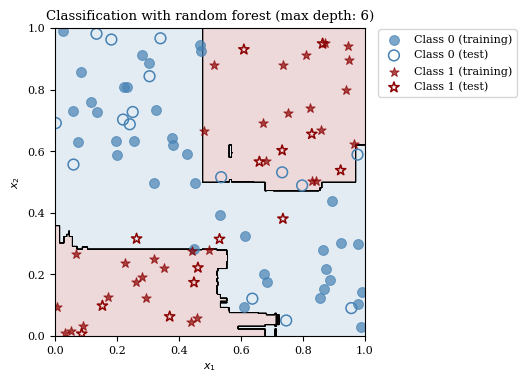

In [62]:
ax = plot_classes(X_train, y_train, X_test, y_test)
plot_decision_boundary(ax, xvalues, forest_cv)
_ = ax.set_title(f'Classification with random forest (max depth: {forest_cv.best_params_["max_depth"]})')

As the output below shows, the cross-validated maximum tree depth of 6 does not lead to any more improvements in accuracy.

In [63]:
y_train_pred_forest = forest.predict(X_train)
y_test_pred_forest = forest.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred_forest)
acc_test = accuracy_score(y_test, y_test_pred_forest)

print(f'Accuracy on training sample: {acc_train:.3f}')
print(f'Accuracy on test sample: {acc_test:.3f}')

Accuracy on training sample: 0.986
Accuracy on test sample: 0.800
